# Raytracing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hephaistos as hp
from ctypes import *

assert hp.isRaytracingSupported(), "Ray tracing is not supported!"
hp.enableRaytracing()

We start by loading the mesh we want to work with.

In [2]:
from stl.mesh import Mesh
mesh = Mesh.from_file("./monkey.stl")
#print number of faces
len(mesh.vectors)

968

## Creating Acceleration Structure

In [3]:
model = hp.Geometry()
model.vertices = np.reshape(mesh.vectors, (-1,3))

In [4]:
instance = hp.GeometryInstance(model)

In [5]:
accStruct = hp.AccelerationStructure([instance])

## Creating image via Ray Tracing

In [6]:
rasterizeSource = """
#version 460
#extension GL_EXT_ray_tracing : enable
#extension GL_EXT_ray_query : enable

layout(local_size_x = 4, local_size_y = 4) in;

uniform accelerationStructureEXT tlas;
layout(rgba8) uniform image2D outImage;

void main() {
    vec2 size = vec2(imageSize(outImage));
    vec2 pos = vec2(gl_GlobalInvocationID.xy);
    vec2 coord = pos / size * 2 - vec2(1.0, 1.0);

    //to things a bit more simple, we render orthogonal in y direction
    //image is in the xz plane; flip y as usual
    vec3 start = vec3(coord.x, -2.0, -coord.y);
    vec3 dir = vec3(0.0, 1.0, 0.0);

    rayQueryEXT rayQuery;
    rayQueryInitializeEXT(
        rayQuery, tlas,
        gl_RayFlagsTerminateOnFirstHitEXT,
        0xFF, start, 0.01, dir, 4.0);

    rayQueryProceedEXT(rayQuery);

    //we render the distance as grey shades
    vec4 color;
    if (rayQueryGetIntersectionTypeEXT(rayQuery, true) == gl_RayQueryCommittedIntersectionTriangleEXT) {
        //hit
        float t = rayQueryGetIntersectionTEXT(rayQuery, true);
        float v = 1 - (t - 1) / 2;
        color = vec4(v, v, v, 1.0);
    }
    else {
        //miss
        color = vec4(0.0,0.0,0.0,1.0);
    }
    imageStore(outImage, ivec2(gl_GlobalInvocationID.xy), color);
}
"""

rasterizeCode = hp.compileSource(rasterizeSource)
rasterize = hp.Program(rasterizeCode)

In [7]:
buffer = hp.ImageBuffer(2048, 2048)
image = hp.Image(hp.ImageFormat.R8G8B8A8_UNORM, 2048, 2048)
rasterize.bindParams(tlas=accStruct, outImage=image)

In [8]:
hp.beginSequence().And(rasterize.dispatch(512, 512)).Then(hp.retrieveImage(image, buffer)).Submit().wait()

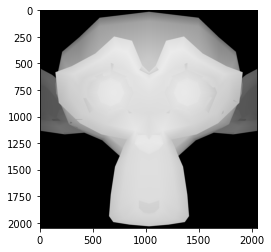

In [9]:
plt.imshow(buffer.numpy())
plt.show()